In [ ]:
# Installing Keras module
!conda install -c conda-forge keras
!pip install -r requirements.txt

In [7]:
# import modules
import json
from pprint import pprint
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances

from sklearn.cluster import SpectralClustering 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score 

# additional set up
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) # suppress scientific float notation

# constants and parameters
DATA_PATH = './quantnet-data/'
IMG_PATH = './'

# load data 
with open(f'{DATA_PATH}data_file_20191119.json') as f:
    data = json.load(f)

In [8]:
# create data frame
df = {'Name': np.zeros(len(data['quantlets'])), 
      'author_of_last_comm': np.zeros(len(data['quantlets'])),
      'is_debuggable': np.zeros(len(data['quantlets'])), 
      'grade': np.zeros(len(data['quantlets'])),
      'keywords': np.zeros(len(data['quantlets']))}

df = pd.DataFrame(data=df)

In [9]:
# extract the columns we need
counter=0
for c, i in enumerate(data['quantlets']):
    df.loc[c,'Name'] = i
    df.loc[c,'author_of_first_comm'] = data['quantlets'][i]['commit_first']['commit']['author']['name']
    df.loc[c,'author_of_last_comm'] = data['quantlets'][i]['commit_last']['commit']['author']['name']
    df.loc[c,'is_debuggable'] = data['quantlets'][i]['is_debuggable']
    try:
        df.loc[c,'grade'] = data['quantlets'][i]['grade']
        df.loc[c,'keywords'] = ' '.join(str(e) for e in set(data['quantlets'][i]['keyword_list']))
    except:
        df.loc[c,'grade'] = 'did not work'
        df.loc[c,'keywords'] ='did not work'
        counter+=1
print(f'Could not load {counter} quantlets.')
df = df[df['is_debuggable']==True]

Could not load 20 quantlets.


In [10]:
df.head()

,Name,author_of_last_comm,is_debuggable,grade,keywords,author_of_first_comm
0,ADM/HermPolyPlot/Metainfo.txt,Lukas Borke,True,A,probability plot basis orthogonal series graph...,chenshic.hub
1,AOBDL_code/codes/metainfo.txt,lizzzi111,True,A,hate speech Lightgbm Ridge Regression Wikipedi...,Elizaveta Zinovyeva
2,ARR/ARRboxage/Metainfo.txt,mariussterling,True,A,descriptive dependence five number summary mul...,AlonaZharova
3,ARR/ARRboxgscit/Metainfo.txt,Lukas Borke,True,A,descriptive dependence five number summary mul...,AlonaZharova
4,ARR/ARRboxhb/Metainfo.txt,Lukas Borke,True,A,descriptive dependence five number summary mul...,AlonaZharova


In [11]:
# text preprocessing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df.keywords.values)
train_X = tokenizer.texts_to_sequences(df.keywords.values, )
train_X = [np.unique(i) for i in train_X]
train_X = pad_sequences(train_X, maxlen=15, padding='post')
#labels = [i.split('/')[1] for i in df.name]
labels = []
for i in df.Name:
    temp = str(i).split('/')
    if len(temp)==3:
        labels.append(temp[1])
    elif len(temp)==2:
        labels.append(temp[0])
    elif len(temp)==4:
        labels.append(temp[2])
    elif len(temp)==5:
        labels.append(' '.join([temp[0],temp[3]]))
    else:
        labels.append(i)

In [12]:
#Calculating cosine similarity affinity matrix
C = cosine_similarity(train_X)

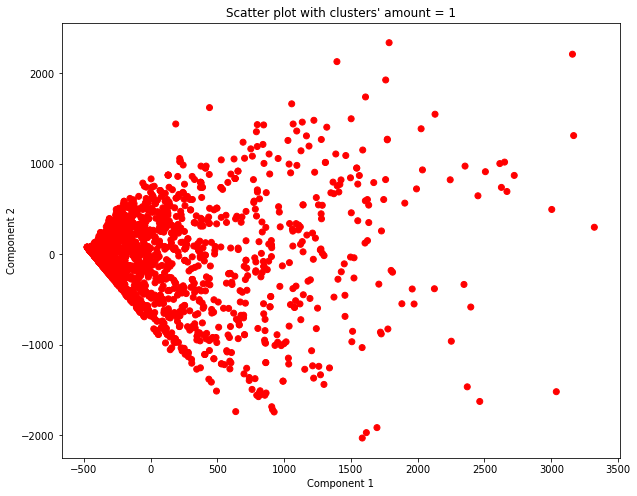

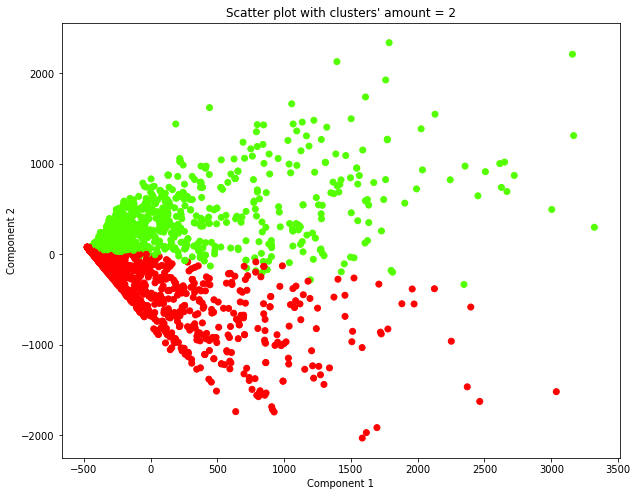

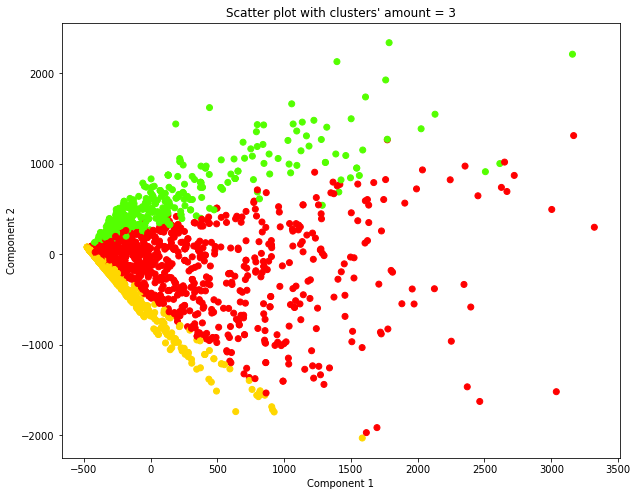

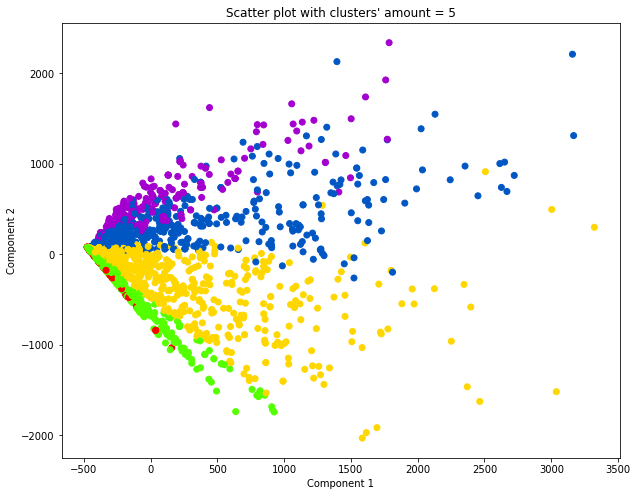

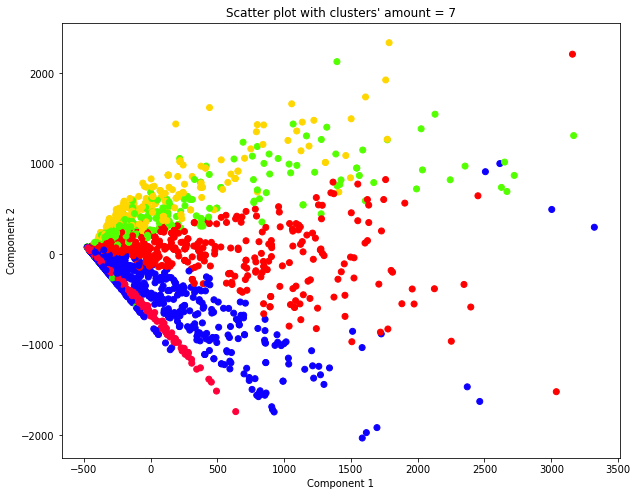

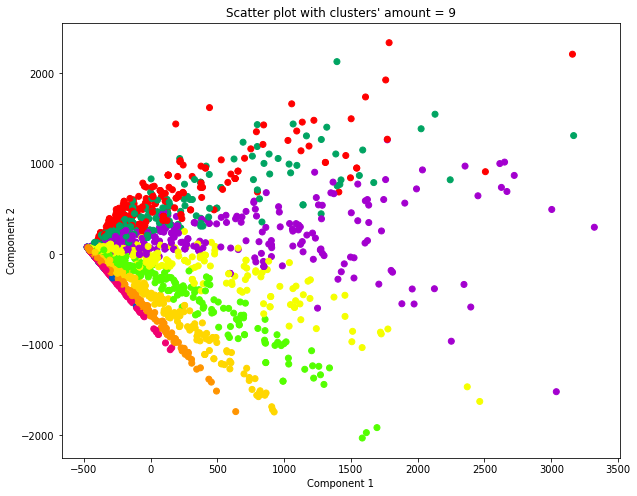

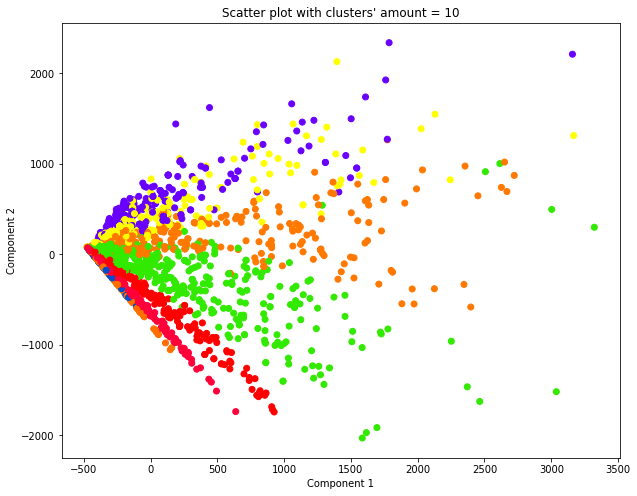

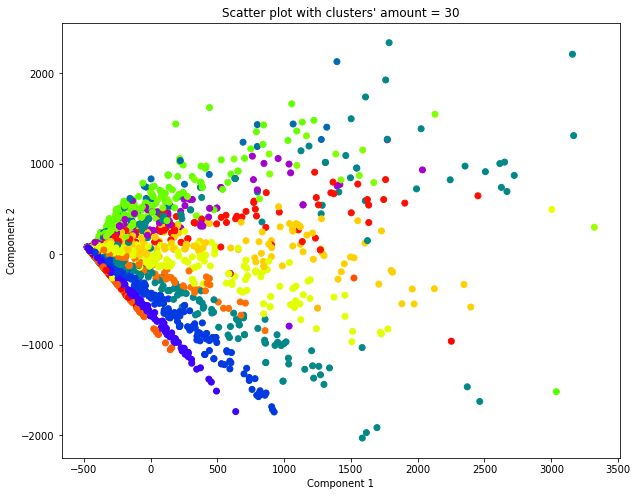

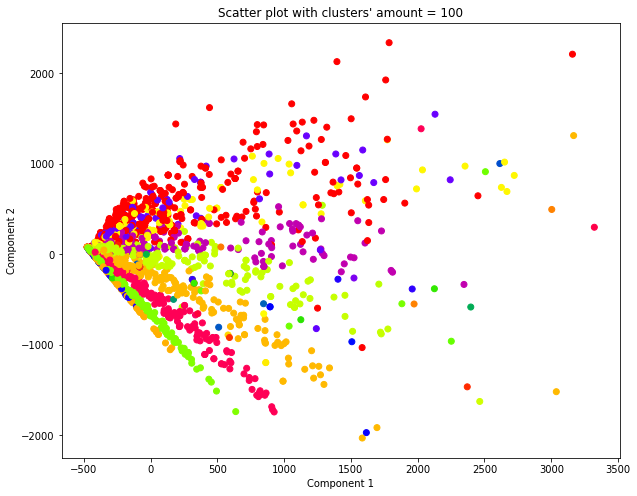

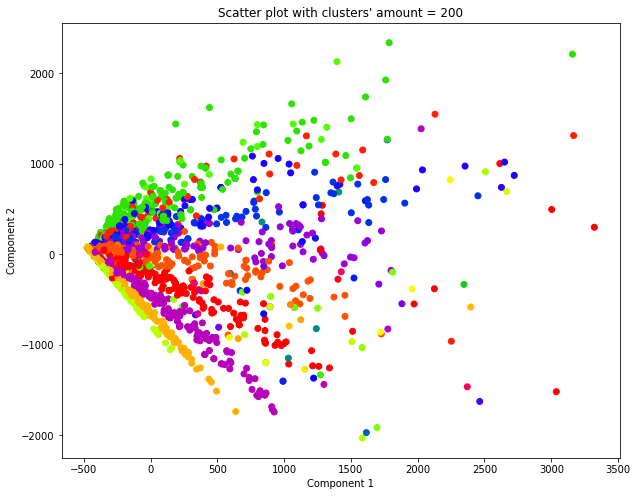

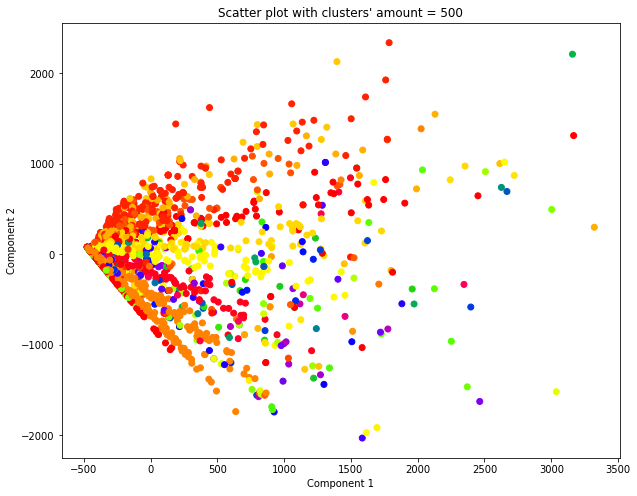

In [8]:
# prepare for plotting
pca = PCA(n_components=2)
pca.fit(train_X)
X = pca.transform(train_X)
for i in [1, 2, 3, 5, 7, 9, 10, 30, 100, 200, 500]:
    max_d = i
    spectral_model_cosine = SpectralClustering(n_clusters = max_d, affinity ='precomputed') 
    clusters = spectral_model_cosine.fit_predict(C) 
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'Scatter plot with clusters\' amount = {i}')
    filename=f'{IMG_PATH}/sc_images/for_sc_gif/step'+str(i)+'.png'
    plt.savefig(filename, dpi=96, transparent=True)
    plt.gca()

In [13]:
#Making 10 clusters using spectral clustering as an example
spectral_model_cosine = SpectralClustering(n_clusters = 10, affinity ='precomputed') 
clusters = spectral_model_cosine.fit_predict(C) 

In [14]:
#Adding cluster labels to the datafram
df['cluster'] = clusters

In [15]:
#Dropping the 'metainfo.txt' from quantlet names to avoid redundancies
df['Name']= df['Name'].str.rstrip('/Metainfo.txt')

#Viewing quantlet names with cluster lables
df[['Name', 'cluster']]

,Name,cluster
0,ADM/HermPolyPl,5
1,AOBDL_code/codes/m,5
2,ARR/ARRboxag,6
3,ARR/ARRboxgsc,6
4,ARR/ARRboxhb,6
...,...,...
2411,topic-models/VisualOverfittingExemp,0
2412,topic-models/VisualTFIDF,1
2413,varuca/VarucaShiny,7
2414,varuca/varuc,7


In [17]:
### Looking at the names of quantlets in a single cluster
clusters = df.loc[df.cluster == 5][['Name']]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(clusters)

                                                   Name
0                                        ADM/HermPolyPl
1                                    AOBDL_code/codes/m
26                                    BCS/BCS_ARM/MetaI
34                                 BCS/BCS_Binpdf/MetaI
37                                BCS/BCS_Boxplot/MetaI
38                               BCS/BCS_Boxplot2/MetaI
47                         BCS/BCS_Conf1sidedleft/MetaI
48                        BCS/BCS_Conf1sidedright/MetaI
49                             BCS/BCS_Conf2sided/MetaI
64                              BCS/BCS_Integrand/MetaI
72                            BCS/BCS_LeaveOneOut/MetaI
73                           BCS/BCS_LightedPlots/MetaI
75                          BCS/BCS_MLRdiagnostic/MetaI
76                               BCS/BCS_MLRleaps/MetaI
80                             BCS/BCS_NPCAbiplot/MetaI
81                                 BCS/BCS_Newton/MetaI
88                              BCS/BCS_PCAbiplo

In [13]:
tsne = TSNE(n_components=2)
tsne.fit(train_X)
X_t = tsne.fit_transform(train_X)

In [14]:
len(df.keywords)

2404

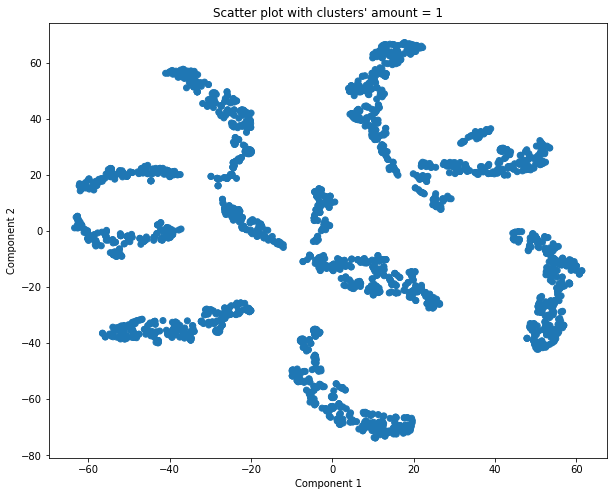

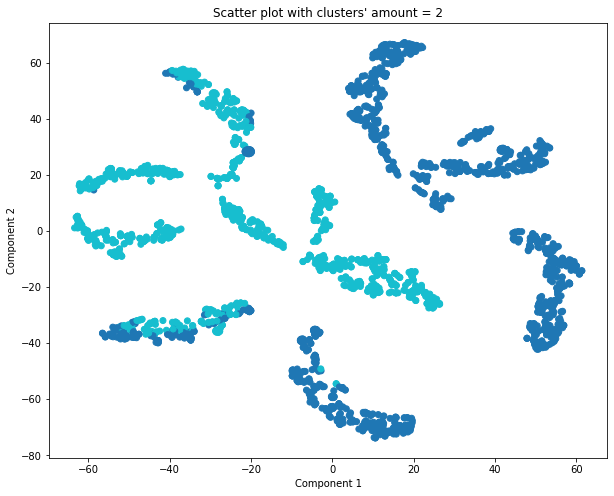

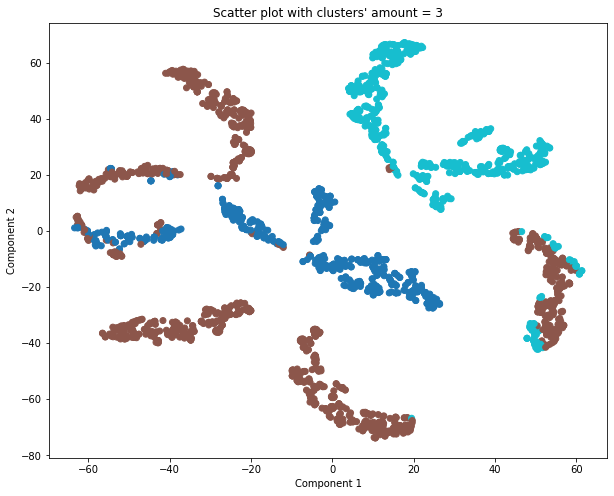

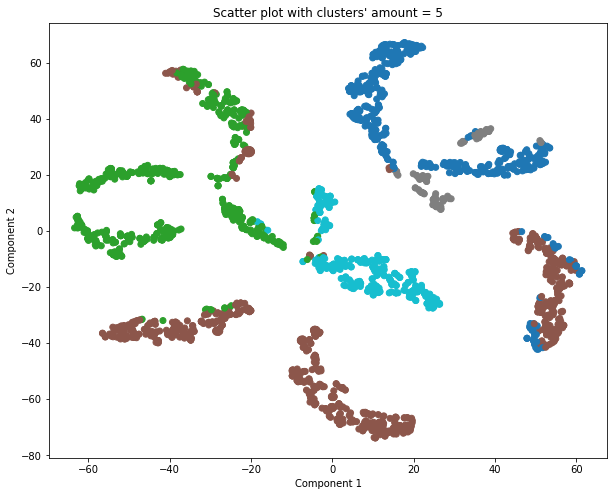

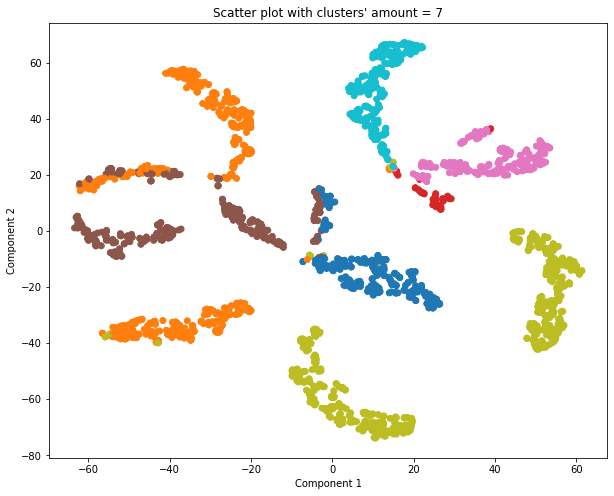

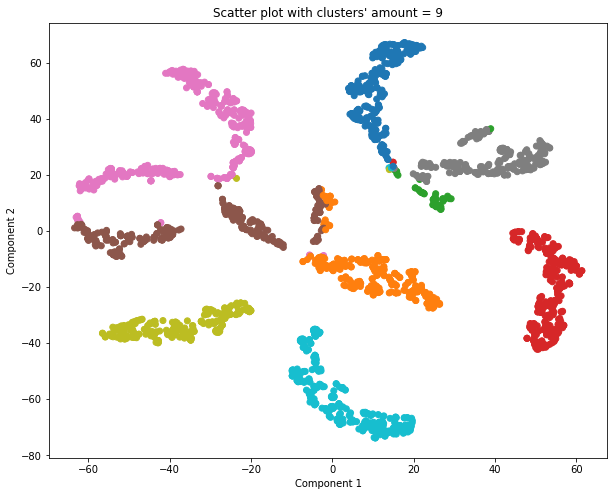

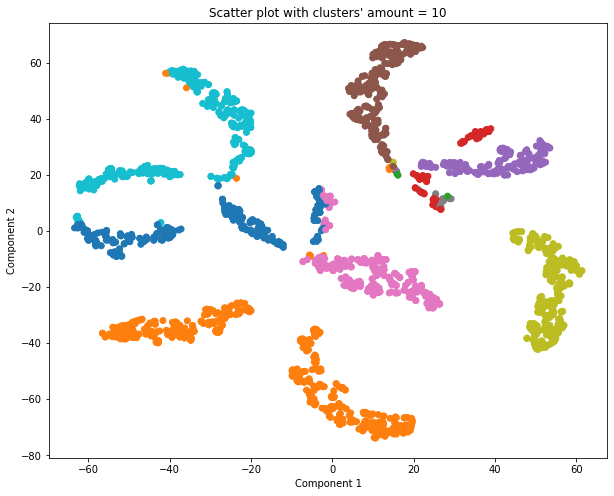

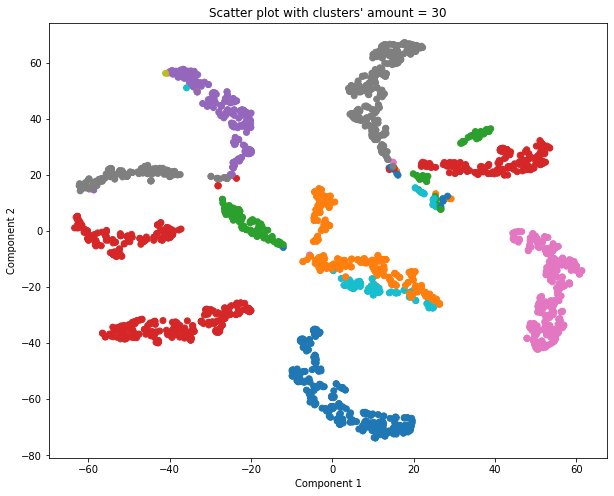

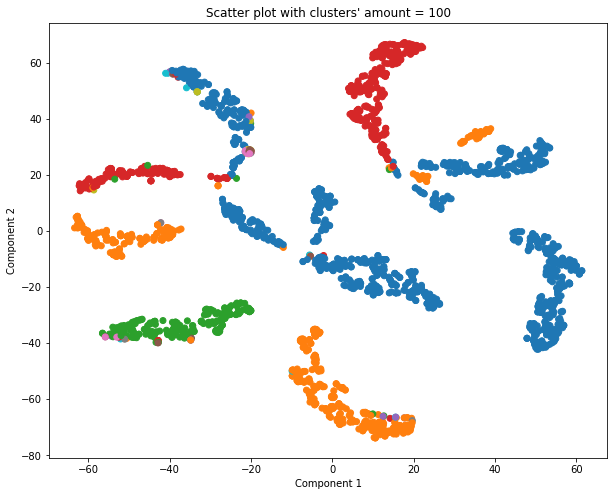

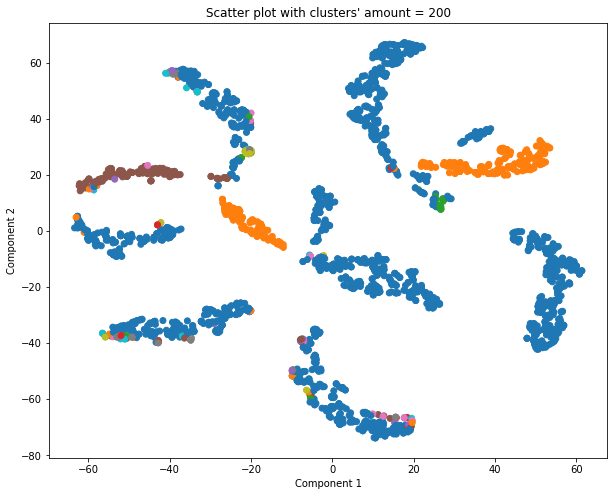

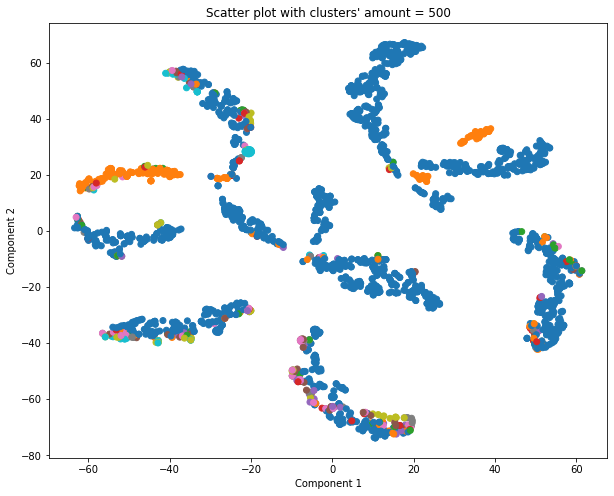

In [16]:
for i in [1, 2, 3, 5, 7, 9, 10, 30, 100, 200, 500]:
    max_d = i
    spectral_model_cosine = SpectralClustering(n_clusters = max_d, affinity ='precomputed') 
    clusters = spectral_model_cosine.fit_predict(C) 
    plt.figure(figsize=(10, 8))
    plt.scatter(X_t[:,0], X_t[:,1], c=clusters, cmap='tab10')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'Scatter plot with clusters\' amount = {i}')
    filename=f'{IMG_PATH}/sc_images/for_sc_gif/TSNE_step'+str(i)+'.png'
    plt.savefig(filename, dpi=96, transparent=True)
    plt.gca()

In [17]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [32]:
max_d = 10
cluster_labels = {}  
for i in range(1, max_d+1):
    df_ = pd.DataFrame(columns = ['word', 'count'])
    df_['word'], df_['count'] = np.unique(train_X[clusters==i], return_counts=True)
    df_ = df_.sort_values(by=['count'], ascending=False)
    #print(df.head(20))
    temp = []
    for word in df_.word.values[1:11]:
        if word != 0:
            temp.append(reverse_word_map[word])
    cluster_labels[i] = ' '.join(temp)     

In [33]:
cluster_labels


{1: 'plot graphical representation visualization data financial time series distribution portfolio',
 2: 'did work not kernel density scagnostics pdf2text vfar combinations worldmap',
 3: 'pareto crix density volatility distribution plot stable crixcoin cryptocurrency lstm',
 4: 'plot visualization simulation distribution graphical time representation series regression copula',
 5: 'data graphical visualization financial series plot time estimation asset returns',
 6: 'plot graphical representation visualization distribution time analysis series returns simulation',
 7: 'plot graphical representation data visualization estimation series time financial model',
 8: 'plot var networks mandatory',
 9: 'plot distribution estimation financial regression density quantile prediction simulation ensemble',
 10: ''}

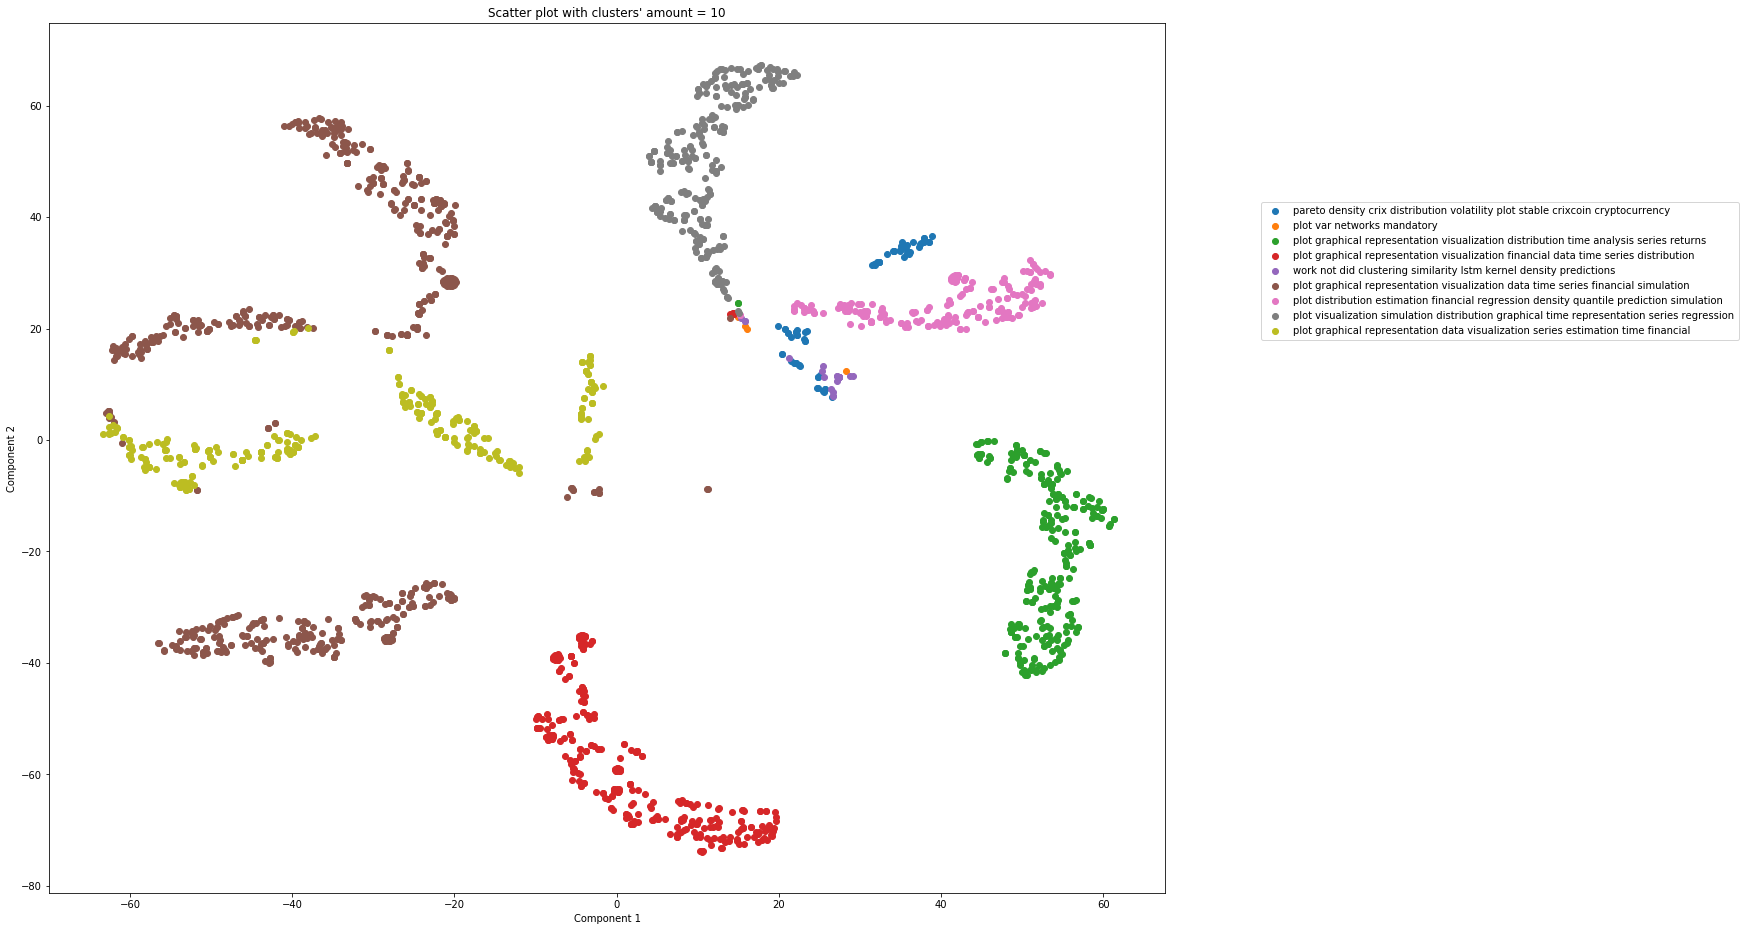

In [34]:
max_d=10
spectral_model_cosine = SpectralClustering(n_clusters = max_d, affinity ='precomputed') 
clusters = spectral_model_cosine.fit_predict(C) 
plt.figure(figsize=(20, 16))
for i in range(1, max_d+1):
    df_ = pd.DataFrame(columns = ['word', 'count'])
    df_['word'], df_['count'] = np.unique(train_X[clusters==i], return_counts=True)
    df_ = df_.sort_values(by=['count'], ascending=False)
    #print(df.head(20))
    temp = []
    for word in df_.word.values[1:10]:
        if word != 0:
            temp.append(reverse_word_map[word])
    cluster_labels[i] = ' '.join(temp)       
    plt.scatter(X_t[clusters==i,0], X_t[clusters==i,1], label = cluster_labels[i])
#plt.legend(loc = 'upper left', prop={'size': 10})
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), prop={'size': 10})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'Scatter plot with clusters\' amount = {10}')
filename=f'{IMG_PATH}/sc_images/TSNE_10_clusters_label.png'
plt.savefig(filename, dpi=96, transparent=True)
plt.gca()